In [1]:
# Dubbi:
#1 come mai le chiavi di a sembrano random?
#2 come faccio a non fare re-inserimento ?? Ricorda io estraggo d-1 cosi, più uno, più un altro che è quello di arrivo

In [1]:
import OffsetArrays
using Plots
using Revise
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
include("./src/functions.jl")

rand_disorder (generic function with 1 method)

In [2]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λp = 0.1 # planted infection rate
λi = 0.1 # inferred infection rate

d = 3 # degree (fixed for now) 
T = 4 # discrete time

γp = 0.1 # planted autoinfection probability
γi = 0.1 # inferred autoinfection probability

N = 5000; #population size

# Population dynamics for the messages

In [3]:
# Creation of the population
# we create μ as the set of all the N functions
# μ[k,ti,ck,τi,σk] is the value taken by the
# function μk with arguments ti,ck,τi,σk
# Using OffsetArrays we managed to keep notation 
# coherent with the notes: 

# i=1,...,N, 
# ti=0,...,T+1 
# c = 0,1
# σ=0,1,2

# The same is done for the ν function later
inizialization = ones(N,T+2,2,T+2,3) / (6*(T+2)^2)
μ = OffsetArrays.OffsetArray(inizialization,0,-1,-1,-1,-1);

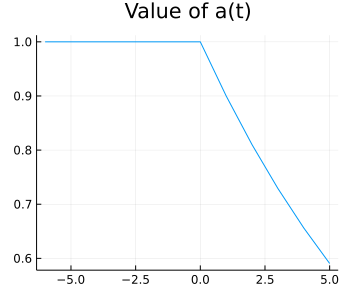

In [4]:
#Precalculation of the function a := (1-λ)^{tθ(t)}, 
#useful for later (the function a appears
#  in the inferred time factor node)

a = Dict(zip(-T-2:T+1,[ t<=0 ? 1 : (1-λi)^t for t = -T-2:T+1]));
μold = copy(μ);
plot(LinRange(-T-2,T+1,2T+4),[a[t] for t=-T-2:T+1],size=(350,300),legend=false,title="Value of a(t)")

In [5]:
ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1);
neighbours = rand(1:N,d-1);

In [11]:
tot_iterations = 20000
@showprogress for iterations = 1:tot_iterations
    # Extraction of disorder: state of individual i: xi0, delays: sij and sji

    xi0,sij,sji = rand_disorder(γp,λp)

    # Initialization of ν=0
    ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    #Extraction of d-1 μ's from population
    neighbours = rand(1:N,d-1)

    #Beginning of calculations: we start by calculating the ν: 
    calculate_ν!(ν,μ,neighbours,xi0,T,γi,a)
    
    # Now we use the ν vector just calculated to extract the new μ.
    # We extract a population index that we call "l".
    # We overwrite the μ in postition μ[l,:,:,:,:]
    l = rand(1:N);

    # First we calculate and store the cumulated of ν with respect to 
    # planted time, i.e. the third argument. We call Σ this cumulated 
    Σ = cumsum(ν,dims=3)
    update_μ!(μ,ν,Σ,l,sij,sji,T)     
end

#p1=plot(reshape(sum(μ,dims=1) ./ N,864))
#p1=plot!(reshape(sum(μold,dims=1) ./ N,864))
#μold = copy(μ);
#plot(p1)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


We plot the heatmaps of the messages

# From messages to marginals

In [12]:
p = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2),-1,-1,-1);
marg = OffsetArrays.OffsetArray(zeros(N,T+2,T+2),0,-1,-1);
max_count = N;

In [13]:
# Now we take out converged population of μ and use it to extract marginals.
# First we extract two ν's and then we combine it in order to obtain a marginal.
# In order to extract a ν we have to extract d-1 μ's. Therefore we extract two groups of 
# d-1 μ's and from them we calculate the two ν's. We also have to extract disorder.
@showprogress for l = 1:max_count
    group1 = rand(1:N,d-1) #groups of neighbours 
    group2 = rand(1:N,d-1)
    
    xi0,sij,sji = rand_disorder(γp,λp) #planted disorder
    xj0 = Int(rand() < γp);
    
    ν1 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)
    ν2 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    calculate_ν!(ν1,μ,group1,xi0,T,γi,a)
    calculate_ν!(ν2,μ,group2,xj0,T,γi,a)

    #Once the ν are calculated we have to cumulate with respect the third argument
    Σ = cumsum(ν2,dims=3)
    update_marginal!(marg,l,ν1,ν2,Σ,sij,sji,T)
end
marg2D = reshape((sum(marg,dims=1)./ max_count),T+2,T+2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


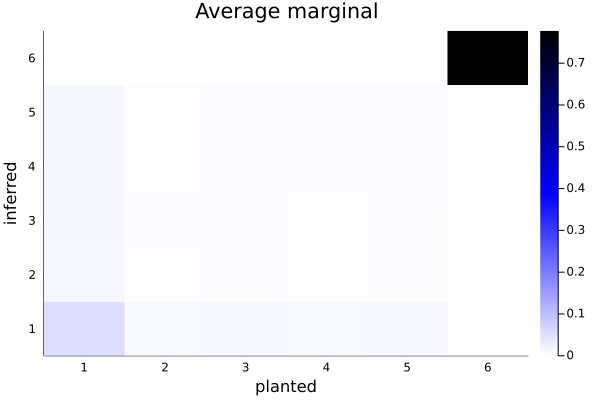

In [14]:
pheat = heatmap((marg2D),c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Average marginal")

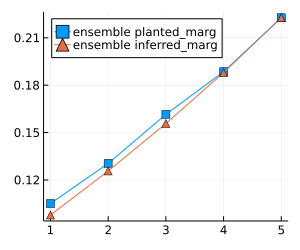

In [140]:
p0 = plot(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),marker=:square,label="ensemble planted_marg")
p0 = plot!(cumsum(sum(marg2D,dims=2)[1:end-1],dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
plot(p0,size=(300,250),legend=:topleft)

# Single Instance Inferernce with Sib

## No disorder
In this regime we don't have disorder, in the sense that the planted distribution is a delta. The planted observation is "all infected"

In [249]:
include("./src/BP.jl")

Ngraph = 10 # size of the single instance graph

G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph #the graph

# observations set in the form of 
# [(individual,state,observation time, false_rate of the test)]
# where state ∈ {0,1} respectively for S and I
# The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
# Instead we go from time 0 to time T 
# I am not completely sure that it is correct to put here T+1 and later a T+2. Maybe is more complicated. 
O = [(i,1,T+1,1e-10) for i=1:Ngraph] 

#we now run the BP algorithm for the single instance defined above
p_sib = sibyl(Ngraph, T+2, G, O, γi, λi; maxit = 40, tol = 1e-7);


sib.iterate(damp=0.0): 9/40 6.471e-09/1e-07      
sib.iterate(damp=0.5): 0/40 2.263e-09/1e-07      


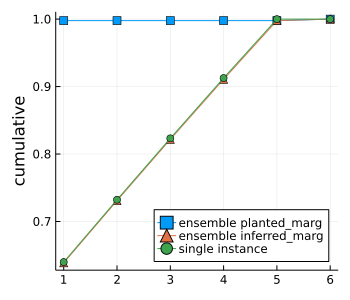

In [250]:
# we plot the marginal distribution and also the ensemble results 

p0 = plot(cumsum(sum(marg2D,dims=1)',dims=1),marker=:square,label="ensemble planted_marg")
p0 = plot!(cumsum(sum(marg2D,dims=2),dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)

p0 = plot!(sum(p_sib,dims=1)'/ Ngraph,marker=:circle,label="single instance")
#p1 = plot!(cumsum(sum(marg2D,dims=2),dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:topleft)
plot(p0,size=(350,300),ylabel="cumulative",)

#savefig("comparison_marg.pdf")

## General framework with disorder
Here the results of observations change because the parameter regime is non trivial. Therefore we need to sample a planted configuration, observe this configuration at final time and infere the single instance. We do this many times and we average so to compare with the ensemble results

### Check of the planted distribution
Here we check with a sampler and with sibyl that the planted ensemble marginal is correct.

In [132]:
include("./src/sampler.jl")
include("./src/BP.jl")

Ngraph = 2500 # size of the single instance graph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory

# First we initialize a single instance marginal y
# which will be the average over graph and particles
# and epidemic trajectory of the marginals
y = zeros(T+1)
yBP = zero(y)
# we average over totst iterations
totst = 15
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # we calculate the cumulative marginal (non-normalized)
    # and we sum it to the average marginal
    y .+= sum(x,dims=1)'
    p_sib = sibyl(Ngraph, T+1, G, [], γi, λi; maxit = 40, tol = 1e-2);
    avgmarg = sum(p_sib,dims=1)' ./ Ngraph
    yBP .+= avgmarg
end
#we normalize the average marginal
y ./= (Ngraph * totst)
yBP ./=  totst

Progress: 100%|█████████████████████████████████████████| Time: 0:00:34



sib.iterate(damp=0.0): 4/40 4.601e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.037e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.184e-05/0.01      
sib.iterate(damp=0.0): 4/40 4.346e-03/0.01      
sib.iterate(damp=0.5): 0/40 9.398e-05/0.01      
sib.iterate(damp=0.9): 0/40 4.699e-05/0.01      
sib.iterate(damp=0.0): 4/40 4.323e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.088e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.441e-05/0.01      
sib.iterate(damp=0.0): 4/40 4.518e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.035e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.176e-05/0.01      
sib.iterate(damp=0.0): 4/40 4.900e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.165e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.825e-05/0.01      
sib.iterate(damp=0.0): 4/40 4.073e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.170e-04/0.01      
sib.iterate(damp=0.9): 0/40 5.852e-05/0.01      
sib.iterate(damp=0.0): 4/40 4.239e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.028e-04/0.01      
sib.iterate(damp=0.

5-element Vector{Float64}:
 0.1000000000000001
 0.1267309000873271
 0.15497667136533758
 0.18471512751643623
 0.2159028154610674

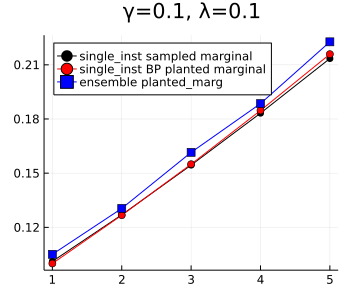

In [133]:
p0 = plot(y,c=:black,marker=:circle,label="single_inst sampled marginal",title="γ=$γp, λ=$λp")
p0 = plot!(yBP,c=:red,marker=:circle,label="single_inst BP planted marginal")
p0 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft)

### Comparison between inference (sibyl) and ensemble results
Here we check instead the results for the inferred marginal

In [134]:
yBP = zeros(T+1)
yBPerr = zero(yBP)
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # observations set in the form of 
    # [(individual,state,observation time, false_rate of the test)]
    # where state ∈ {0,1} respectively for S and I
    # The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
    # Instead the ensemble goes from time 0 to time T  
    O = [(i,x[i,T+1],T+1,1e-10) for i = 1:Ngraph]
    #we now run the BP algorithm for the single instance defined above
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-2);
    yBP .+= sum(p_sib,dims=1)'
    yBPerr .+= sum(p_sib ,dims=1)' .^ 2
end

yBP ./= (Ngraph * totst)
yBPerr ./= (Ngraph^2 * totst)
yBPerr .= sqrt.(yBPerr .- yBP .^ 2) / sqrt(totst)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:39



sib.iterate(damp=0.0): 6/40 5.529e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.327e-03/0.01      
sib.iterate(damp=0.9): 0/40 6.635e-04/0.01      
sib.iterate(damp=0.0): 6/40 5.221e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.265e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.133e-03/0.01      
sib.iterate(damp=0.0): 6/40 7.070e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.118e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.191e-04/0.01      
sib.iterate(damp=0.0): 6/40 3.069e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.712e-04/0.01      
sib.iterate(damp=0.9): 0/40 1.876e-04/0.01      
sib.iterate(damp=0.0): 6/40 4.112e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.036e-03/0.01      
sib.iterate(damp=0.9): 0/40 5.180e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.663e-03/0.01      
sib.iterate(damp=0.5): 0/40 6.625e-04/0.01      
sib.iterate(damp=0.9): 0/40 3.313e-04/0.01      
sib.iterate(damp=0.0): 6/40 1.790e-03/0.01      
sib.iterate(damp=0.5): 0/40 8.509e-04/0.01      
sib.iterate(damp=0.

5-element Vector{Float64}:
 0.001499764534050725
 0.0019676053044713196
 0.0024919617426035594
 0.0030560072025677784
 0.0036506786786099023

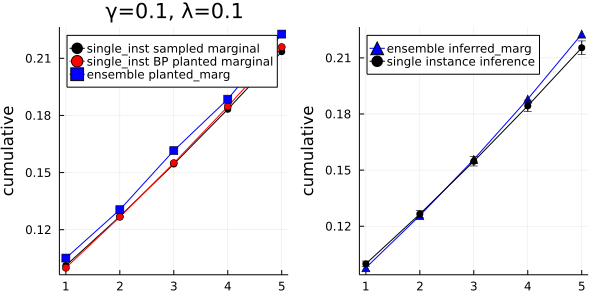

In [135]:
p1 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:blue,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p1 = plot!(yBP,yerr=yBPerr,c=:black,marker=:circle,label="single instance inference")
plot(p0,p1,size=(600,300),ylabel="cumulative",legend=:topleft)
#savefig("sibVSepid")